# Keras mnist example

### Import required libraries

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load the dataset

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

## Exploratory Analysis

Here we want to get a better understanding of our dataset. We viusalise some of the images, and gather some simple statistics.

It's encouraged here to eplore the dataset more!

#### Visualize some images

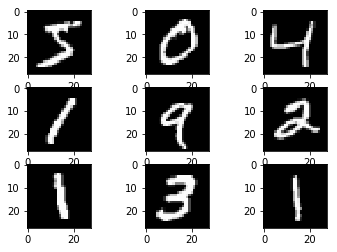

In [5]:
for row in range(3):
    for col in range(3):
        idx = row*3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(X_train[idx-1], cmap="gray")
        

#### Basic Dataset Statistics

In [6]:
num_classes = np.unique(Y_train).shape[0]
print("Number of training examples:", X_train.shape[0])
print("Number of testing examples:", X_test.shape[0])
print("Number of classes:", num_classes)
print("Image shape:", X_train[0].shape)
print("Image data type:", X_train.dtype)

Number of training examples: 60000
Number of testing examples: 10000
Number of classes: 10
Image shape: (28, 28)
Image data type: uint8


#### Plot class distribution

<BarContainer object of 10 artists>

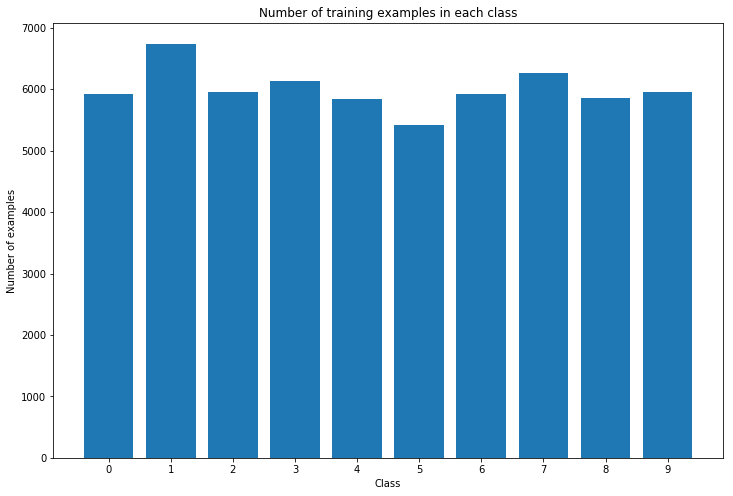

In [7]:
class_distribution = Counter(Y_train)
x = range(10)
y = [class_distribution[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of training examples in each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, y)

### Data pre-processing

Data pre-processing is an important step for neural networks. You always want to normalize your data, and you might consider performing data-augmentation to increase the variety of your training set. Here we will only perform data-normalization.

We perform pixel-wise normalization

In [8]:
pixel_mean = X_train.mean(axis=0)
pixel_std = X_train.std(axis=0) + 1e-10 # Prevent division-by-zero errors
# Normalize the train and test set
X_train = (X_train - pixel_mean) / pixel_std
X_test = (X_test - pixel_mean) / pixel_std


#### Visualize the normalized data

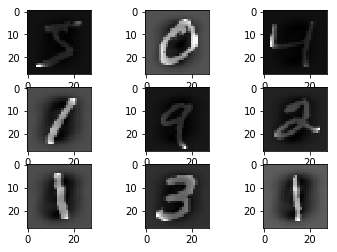

In [9]:
for row in range(3):
    for col in range(3):
        idx = row*3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(X_train[idx-1], cmap="gray")
        

### Transform labels to one-hot encoding

In [10]:
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

### Change data shape
If keras is using tensorflow backend, it expect the image format to be
(Height, Width, Number of channels).
In our case the MNIST images are graysale, with a shape of (28, 28). 
Therefore we convert our data to the required shape of tensorflow, which is (28, 28, 1)

In [11]:
print("Old shape:", X_train.shape)
X_train = X_train[:,:,:, np.newaxis].astype(np.float32)
X_test = X_test[:,:,:, np.newaxis].astype(np.float32)
print("New shape:", X_train.shape)

Old shape: (60000, 28, 28)
New shape: (60000, 28, 28, 1)


#### Split training set into training and validation

We want to use a validation set to validate our model, and keep the test set for testing purposes only.
The testing set is only for final evaluation, while we use the validation set to tune different hyperparameters in our model.

In [12]:
train_val_split = 0.9 # Percentage of data to use in training set
indexes = np.arange(X_train.shape[0])
np.random.shuffle(indexes)
# Select random indexes for train/val set
idx_train = indexes[:int(train_val_split*X_train.shape[0])]
idx_val = indexes[int(train_val_split*X_train.shape[0]):]

X_val = X_train[idx_val]
Y_val = Y_train[idx_val]

X_train = X_train[idx_train]
Y_train = Y_train[idx_train]

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (54000, 28, 28, 1)
Validation set shape: (6000, 28, 28, 1)
Testing set shape: (10000, 28, 28, 1)


### Model Construction

Here we will build a very simple fully connected neural network, with the following layers:

- Flatten layer. Required to feed into our fully-connected layer. 
- Fully connected layer (Dense) with 10 output units
- Softmax activation function

In [13]:
model = Sequential()
input_shape = X_train.shape[1:] # (28, 28, 1)
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(num_classes, activation="softmax"))

Keras requires the input shape of the first layer of your model. It automatically computes the input shapes of the following layers.



### Compilation, optimization function and loss metric

We then compile our model where the inputs are the following:

- Loss: The loss function we want to minimize. In this case it is the categorical cross entropy loss.
- Optimizer: The optimizer function we want to use. Here we choose Stochastic Gradient Descent. There is a lot of choices on optimizers, you can read more about them [here](https://keras.io/optimizers/)
- Metrics: The metric we want to track. You can read more about different metrics [here](https://keras.io/metrics/)

In [14]:
learning_rate = 0.1
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=learning_rate),
              metrics=['accuracy'])

### Model summary

Keras has a very useful function to see how many parameters and the output shapes of each layer.

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Train our model

We set the number of epochs we want to train for, and also the batch size we want to use.

The model is evaulated after each epoch on the validation set.

In [16]:
number_of_epochs = 10
batch_size=128

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=number_of_epochs,
          verbose=1,
          validation_data=(X_val, Y_val))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 1s 12us/step - loss: 0.4134 - acc: 0.8863 - val_loss: 0.3144 - val_acc: 0.9103
Epoch 2/10
54000/54000 [==============================] - 0s 9us/step - loss: 0.3089 - acc: 0.9155 - val_loss: 0.3089 - val_acc: 0.9108
Epoch 3/10
54000/54000 [==============================] - 1s 9us/step - loss: 0.2934 - acc: 0.9202 - val_loss: 0.2982 - val_acc: 0.9153
Epoch 4/10
54000/54000 [==============================] - 0s 9us/step - loss: 0.2816 - acc: 0.9233 - val_loss: 0.2988 - val_acc: 0.9168
Epoch 5/10
54000/54000 [==============================] - 0s 9us/step - loss: 0.2763 - acc: 0.9251 - val_loss: 0.2979 - val_acc: 0.9180
Epoch 6/10
54000/54000 [==============================] - 1s 9us/step - loss: 0.2708 - acc: 0.9264 - val_loss: 0.2921 - val_acc: 0.9192
Epoch 7/10
54000/54000 [==============================] - 0s 9us/step - loss: 0.2658 - acc: 0.9276 - val_loss: 0.2972 - val_acc: 0.916

### Visualization and analysis
The fit function tracks loss and accuracy on both the training and validation data. 

We can then use these metrics to visualize and analyze the performance of our model

#### Loss history

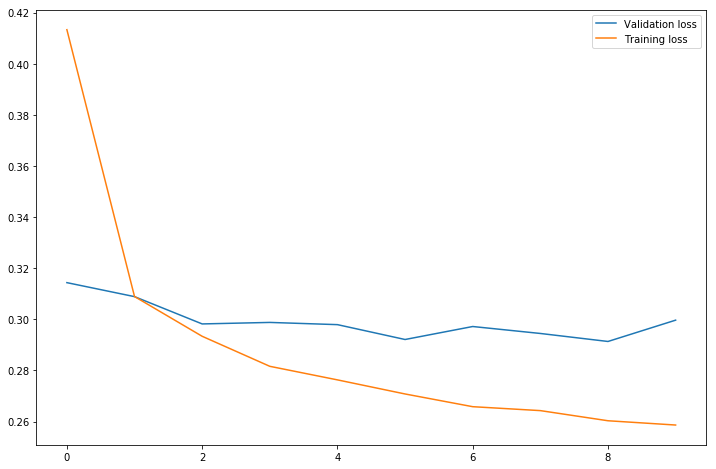

In [17]:
history = model.history.history
plt.figure(figsize=(12, 8))
plt.plot(history["val_loss"], label="Validation loss")
plt.plot(history["loss"], label="Training loss")
plt.legend()

Something to notice here is the gap between the validation loss and training loss. This might indicate that our model is overfitting on the training set, even though the validation loss is not increasing.

#### Accuracy history

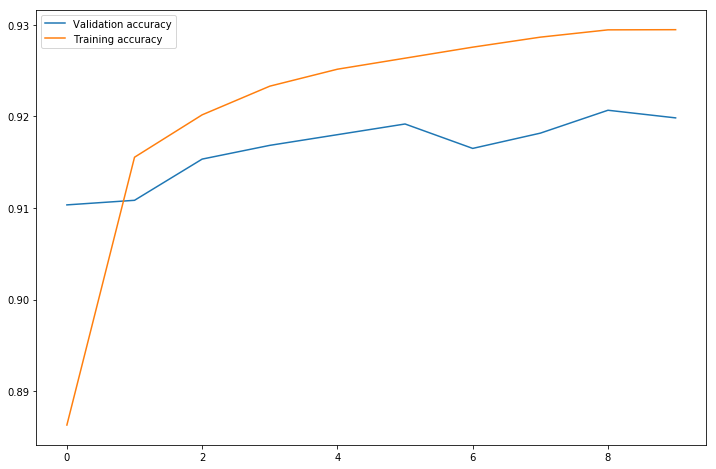

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(history["val_acc"], label="Validation accuracy")
plt.plot(history["acc"], label="Training accuracy")
plt.legend()

## Final evaluation on test set 

Here we want to perform our final evaluation of our model on the test-set. 


In [19]:
final_loss, final_accuracy = model.evaluate(X_test, Y_test)
print("The final loss on the test set is:", final_loss)
print("The final accuracy on the test set is:", final_accuracy)

10000/10000 [==============================] - 0s 10us/step
The final loss on the test set is: 0.30260410766601564
The final accuracy on the test set is: 0.9228


We can then compare the test loss on our previous plot.

Notice that the test loss is very close to our validation loss. This indicates that our validation set is a good indicator of the models performance on the test set.

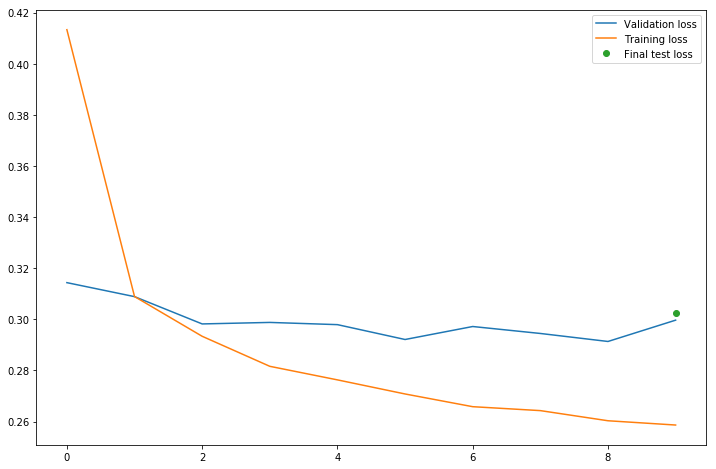

In [20]:
history = model.history.history
plt.figure(figsize=(12, 8))
plt.plot(history["val_loss"], label="Validation loss")
plt.plot(history["loss"], label="Training loss")
plt.plot([9], [final_loss], 'o', label="Final test loss")
plt.legend()

# Final notes

You have now built your first model with Keras. The model we implemented was a very shallow and simple model, and this model will significantly improve if you add more layers/complexity to it.

Some improvements for this architecture could be:

- Using data augmentation on the training set. This could include translation, rotation, scaling, color augmentation etc... [This](https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258) blog post gives a quick introduction to data pre-processing
- Using more layers. Our network is very shallow, and will benefit of additional layers.
- Introducing techniques such as dropout, batch normalization
- Experimenting with optimization algorithms. We used SGD, but there are several options such as AdaDelta, Adam, RMSProp ...
- Hyperparameter tuning: This might include learning rate, batch size, number of layers, number of filters etc..

We performed very simple data analysis to evaluate our model. This can be further worked on to improve our understanding on where our model works good, and where it suffers. Some metrics and visualiation methods we recommend is:

- Precision, Recall, F1-score metrics
- Confusion Matrix
- Precision-Recall curve


Remember, you need to understand every method you choose to use in your project. We might ask questions about the different methods you implement in the final presentation